# Задание 4
Проверить мощность и консервативность критерия Уликоксона о равенстве медиан для выборок вида:
X1: ~ alpha * N(0,1) + (1-alpha)*N(2, 4)
X2: ~ alpha * N(0,1) + (1-alpha)*N(2, 4) + delta.
**Важно** распределение является гауссовой смесью, это не сумма гауссовых величин.

Здесь delta --- сдвиг, дающий возможность разделить выборки X1 и X2.

Изучить зависимость от alpha и delta.

## Сылки
https://stackoverflow.com/questions/49106806/how-to-do-a-simple-gaussian-mixture-sampling-and-pdf-plotting-with-numpy-scipy

In [129]:
import numpy as np
import numpy.random
import scipy.stats as st
import matplotlib.pyplot as plt
import ipywidgets as widg
import seaborn as sns
from numpy.random import random as random
from tqdm import tqdm_notebook as tqdm

# Генератор выборок

In [130]:
norm_params = np.array([[0, 1], [2, 4]])
def gen_gauss_mix(n=1000, params=norm_params, weights=[0.1, 0.9]):
    mixture_idx = numpy.random.choice(len(weights), size=n, replace=True, p=weights)
    y = numpy.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx), dtype=np.float64)
    return y

# Сравним теоретическое и эмпиприческое распределение при различных alpha

In [131]:
def plotMix(alpha):
    gauss_weights = np.array([alpha, 1-alpha])
    y = gen_gauss_mix(weights=gauss_weights, n=10000)

    xs = np.linspace(y.min(), y.max(), 200)
    ys = np.zeros_like(xs)
    for (l, s), w in zip(norm_params, gauss_weights):
        ys += st.norm.pdf(xs, loc=l, scale=s) * w

    f, ax = plt.subplots(1, 2,figsize=(16,4))
    ax[0].plot(xs, ys, label='theoretical')
    sns.distplot(y, label='empirical', ax=ax[0])
    sns.boxplot(y, ax=ax[1])
    ax[0].legend()
    plt.show()
# plotMix(0.2)

In [132]:
widg.interact(plotMix, alpha=(0, 1, 0.1))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

<function __main__.plotMix(alpha)>

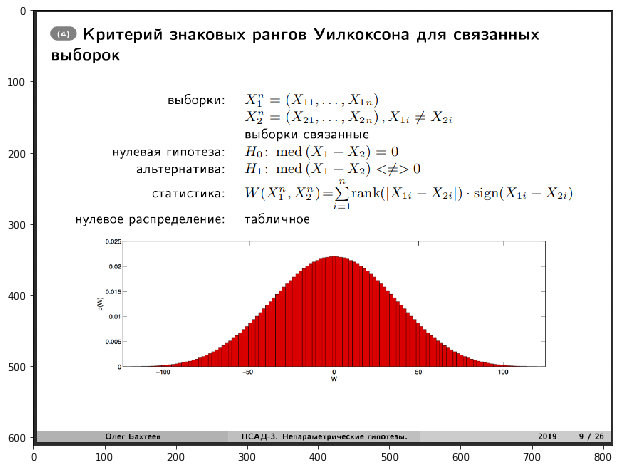

In [133]:
plt.figure(figsize=(16,8)) #todo: change to vector image
plt.imshow(plt.imread('slide.png'))

# Пример

In [134]:
delta = 0.3
st.wilcoxon(gen_gauss_mix() - gen_gauss_mix() - delta)

WilcoxonResult(statistic=235150.0, pvalue=0.09835477664816845)

# Вычисление  мощности

In [135]:
aLevel = 0.05
def power(alpha, delta, N = 100, verbose=True):
    if (not verbose):
        global tqdm
        tqdm = lambda x: x
    pvalues = [st.wilcoxon(
    gen_gauss_mix(weights=[alpha, 1-alpha]) - gen_gauss_mix(weights=[alpha, 1-alpha]) - delta)[-1]
            for alpha in tqdm(random(N))]
    pvalues = np.array(pvalues)
    res = np.count_nonzero(pvalues<aLevel)/len(pvalues)
    from tqdm import tqdm_notebook as tqdm
    return res
    
powerV = np.vectorize(power)

In [139]:
from tqdm import tqdm_notebook as tqdm

# Будем считать, что при delta = 0, H0 - истинна, а при delta != 0 - ложна
# Тогда функция() power находит мощность при delta != 0, и ошибку I рода, когда delta = 0 

# Построим график зависимости мощности от delta при разных alpha

CPU times: user 22min 44s, sys: 1.24 s, total: 22min 45s
Wall time: 22min 43s


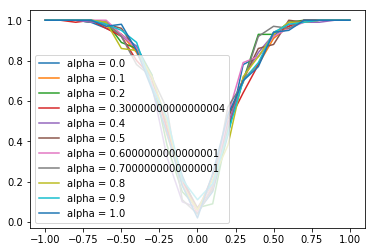

In [140]:
%%time
delta = np.linspace(-1, 1, 21)
for alpha in tqdm(np.linspace(0, 1, 11)):
    plt.plot(delta, powerV(alpha, delta, verbose=False), label='alpha = '+str(alpha))
plt.legend()

# Критерий считается конcервативным, если ошибка первого рода не превосходит aLevel

In [142]:
powerV(np.linspace(0, 1, 11), 0, verbose=True)

array([0.05, 0.03, 0.04, 0.05, 0.03, 0.02, 0.03, 0.06, 0.07, 0.03, 0.01])

# Таким образом критерий в пограничном состоянии